In [100]:
import random
import gensim.matutils as gm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import math
import numpy as np
from gensim import corpora, models
from tqdm import tqdm
from scipy.spatial.distance import cosine
from tqdm import tnrange as prange, tqdm_notebook as pbar
import copy
import sklearn
from sklearn.cross_validation import *
from collections import Counter
import pickle
import re
import pandas as pd
import scipy.stats as sps
from itertools import count

$ \lbrace \xi_n, n \in \mathbb{Z}_+ \rbrace , \xi_i \sim \mathcal{N}(0, 1)$ Вот такой у нас процесс: $X_t = \frac{\xi_0t}{\sqrt{\pi}} + \sqrt{\frac{2}{\pi}} \cdot \sum\limits_{k = 1}^\infty \frac{\sin{(kt)}}{k} \cdot \xi_k$, на отрезке $[0 , \pi]$


Напишите класс, который будет моделировать винеровский процесс на основе задачи 3.6 из сборника задач. В сумме берите первые 𝑛 слагаемых. Интерфейс должен быть примерно таким (подчеркивания обязательны!):


In [101]:
symbols = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
def color_generator():
    color = '#'
    for i in range(6):
        index = 0
        for j in range(1000) :
            index = random.randint(0, 15)
        color += (symbols[index])
    return color

In [3]:
np.pi

3.141592653589793

In [102]:
# TIME IN [0, PI]
class WinerProcess:
    precision = 0
    _ids = count(0)
    def __init__(self, precision = 10000):
        self.id = next(self._ids)
        self.precision = precision
        self.samples = {}
        self.cumsum = []
        
    def _X_t(self, t):
        dot = t % np.pi
        div_pi = int (t / np.pi)
        sqrt_pi = np.sqrt(np.pi)
        sqrt_2_div_pi = np.sqrt(2 / np.pi)
        vsin = np.vectorize(np.sin)
        if div_pi not in self.samples:
            self.samples[div_pi] = np.divide(sps.norm.rvs(size=self.precision), np.arange(1, self.precision + 1))
            if len(self.cumsum) == 0:
                #np.append(self.cumsum, self.samples[div_pi][0] * sqrt_pi)
                self.cumsum.append(self.samples[div_pi][0])
            else:
                #np.append(self.cumsum, self.cumsum[-1] + self.samples[div_pi][0] * sqrt_pi)
                self.cumsum.append(self.cumsum[-1] + self.samples[div_pi][0]) # при условии, что все величины для более ранних моментов уже сгенерированы
        return self.cumsum[div_pi] + (self.samples[div_pi][0] * dot) / sqrt_pi + np.sqrt(2 / np.pi) * np.sum(self.samples[div_pi] * vsin(np.arange(self.precision) * t))
#np.sum(list(map(lambda k: (np.sin((k + 1) * dot) / (k + 1)) * self.samples[div_pi][k],range(self.precision))))

    def _X_t_without_shift(self, t):
        dot = t % np.pi
        div_pi = int (t / np.pi)
        if div_pi not in self.samples:
            self.samples[div_pi] = sps.norm.rvs(size=self.precision)
        
        return (self.samples[div_pi][0] * dot) / np.sqrt(np.pi) + np.sqrt(2 / np.pi) * np.sum(list(map(lambda k: (np.sin((k + 1) * dot) / (k + 1)) * self.samples[div_pi][k],range(self.precision))))

    
    #def _get_values(self, t):
        


    def __getitem__(self, times): 
        
        
        return list(map(lambda t: self._X_t(t), tqdm(times)))

In [112]:
# Созжажим экземпляр класса
a = WinerProcess()
a[[1,3, 4]]


100%|██████████| 3/3 [00:00<00:00, 77.76it/s]

[1.3301761490167368, 2.2537695458982934, -2.020253806997153]

In [169]:
type(a.samples[0])

numpy.ndarray

# СКЛЕИТЬ!
Посмотрим на значение нашего процесса в точке $\pi.  X_{\pi} = \xi_0  \sqrt{\pi} +  \sqrt{\frac{2}{\pi}} * \sum\limits_{k = 1}^{+\infty}\frac{\sin{\pi k}}{k} \cdot \xi_k = \xi_0 \sqrt{\pi}$, т.к. $\sin{\pi k } = 0$. То есть для момента времени $\pi * l \leq t_0 \leq \pi * (l + 1)$, будем сдвигать значение в этой точке на $\sqrt{\pi}\sum\limits_{0 \leq k \leq l}\xi_{k_0}$. Для этого посчитаем масив cumsum, чтобы не считать все несколько раз

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 25%|██▌       | 2506/10000 [00:00<00:00, 25050.23it/s]

 50%|█████     | 5006/10000 [00:00<00:00, 25034.23it/s]

 75%|███████▍  | 7475/10000 [00:00<00:00, 24929.50it/s]

 96%|█████████▌| 9620/10000 [00:00<00:00, 23771.12it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.22it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 24%|██▎       | 2353/10000 [00:00<00:00, 23522.90it/s]

 45%|████▍     | 4493/10000 [00:00<00:00, 22841.63it/s]

 68%|██████▊   | 6850/10000 [00:00<00:00, 23054.29it/s]

 93%|█████████▎| 9286/10000 [00:00<00:00, 23430.78it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 22%|██▏       | 2230/10000 [00:00<00:00, 22299.33it/s]

 31%|███       | 3077/10000 [00:00<00:00, 14954.29it/s]

 38%|███▊      | 3799/10000 [00:00<00:00, 6412.45it/s] 

 48%|████▊     | 4766/10000 [00:00<00:00, 7132.27it/s]

 71%|███████▏  | 7145/10000 [00:00<00:00, 9028.85it/s]


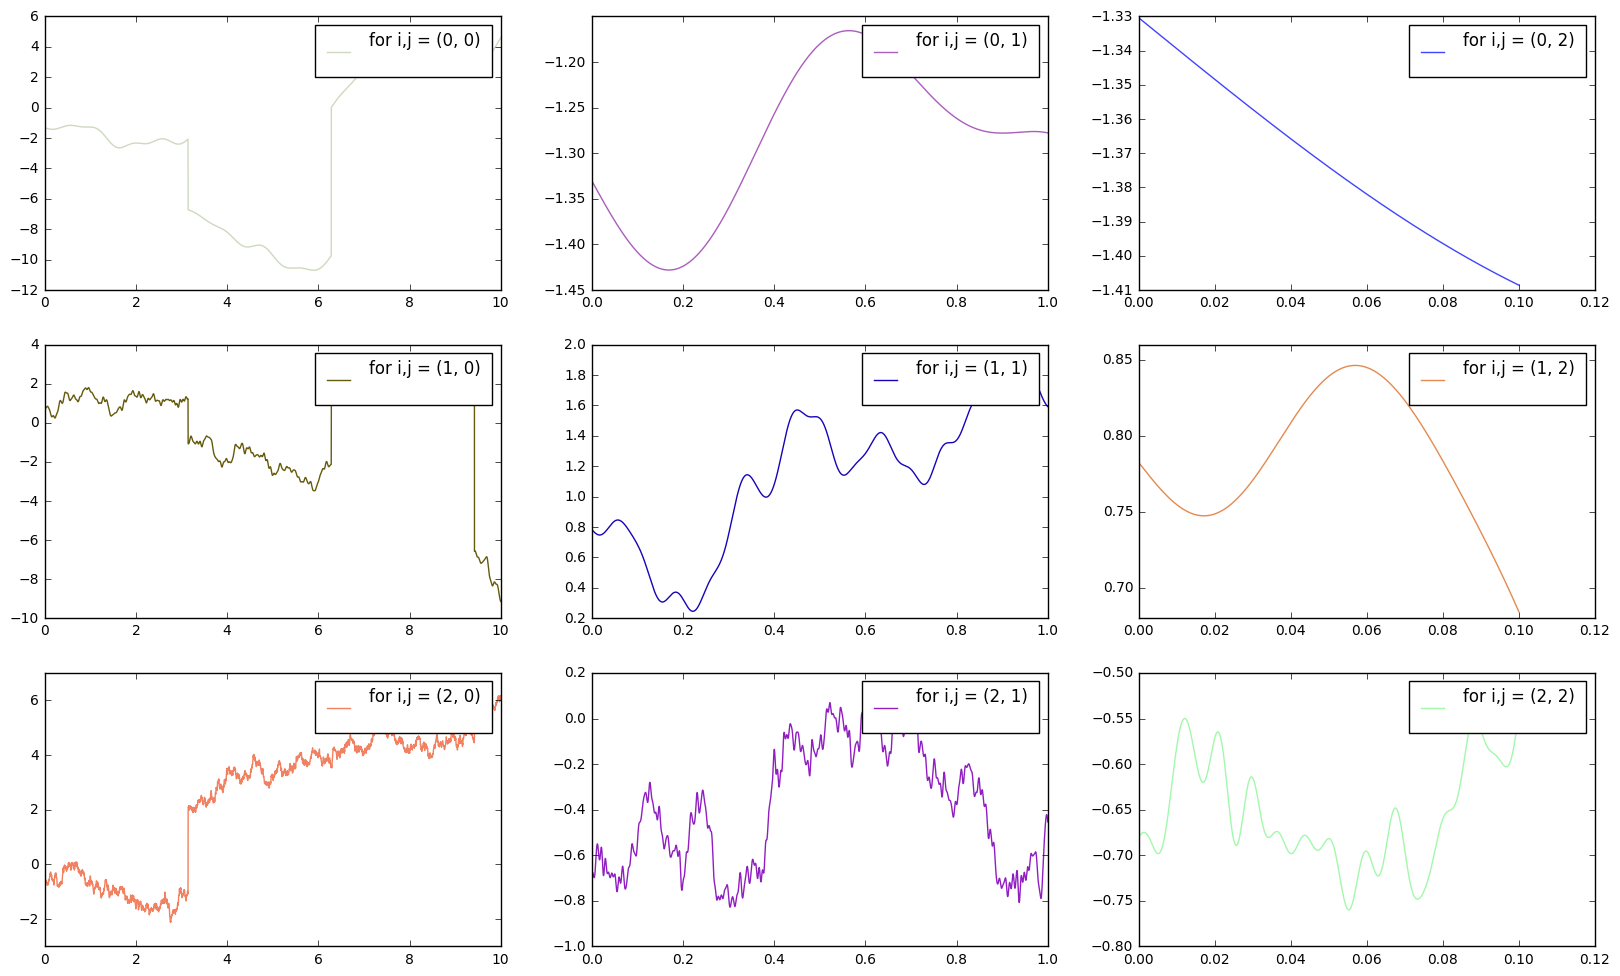

CPU times: user 1min 34s, sys: 2.78 s, total: 1min 37s
Wall time: 1min 44s


In [134]:
%%time
precisions = [10, 100, 1000]
intervals = [10, 1, 0.1]
plt.figure(figsize=(20,12))
for i in tqdm(range(3)):
    Wt = WinerProcess(precisions[i])
    cumsum = {}
    for j in tqdm(range(3)):
        iter_nums = math.ceil(intervals[j] / np.pi)
        dots = np.linspace(0, intervals[j], 10000)
        maximal_time = np.max(dots)        
        ax = plt.subplot(3,3, i * 3 + j + 1)
        ax.plot(dots, Wt[dots], color=color_generator(), label = 'for i,j = (' + str(i) + ', ' + str(j) + ') \n')
        plt.legend()
plt.show()

# Мб проблемы

In [6]:
# Склеить тяжело(слишком большое расстояние между соседними точками)
# С помощью tqdm определил, что работать будет около 40 минут :(
Wt = WinerProcess()
t = np.linspace(0, 10 ** 7, 10 ** 5)
values = Wt[t]

  0%|          | 0/100000 [00:00<?, ?it/s]


IndexError: list index out of range

У нас была теоретическая задача в параграфе про Винеровские процессы: Если $(W_t, t \geq 0)$ - винеровский, доказать, что процесс $X_t = \sqrt{c} \cdot W_{\frac{t}{c}}$ - тоже винеровский. Т.е. для задачи генерации значений в точках вида $t_i = step \cdot i$ мы можем наш процесс $W_t$ немного изменить, чтобы упростить вычисления, напрмимер, можем сделать так, чтобы все $t_i \to \pi \cdot k$. Тогда синусы занулятся и ответом будет лишь $\xi_{k_0} \cdot \sqrt{\pi}$. Чтобы сделать это, возбьмем константу с равной $ c =  \frac{step}{\pi} $. Тогда синусы будут считаться в точках, кратных $\pi \Rightarrow$ они занулятся и останется лишь $\sqrt{c} \cdot \xi_0 \sqrt{\pi}$

In [176]:
print(np.pi * 50000 / 0.1 )   # Максимальное время, которое будет у винеровского. Кол-во отрезков длины - это число поделить на пи
print(50000 / 0.1)  # Количество точек времени для X_t. 

1570796.3267948963
500000.0


In [8]:
def winer_proccess_path(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    c = (100000 * step) / (np.pi)
    sample = sps.norm.rvs(size=len(times))
    cumsum = np.cumsum([0] + np.sqrt(np.pi) * sample)
    values = [np.sqrt(c) * (sample[i]*times[i] / (np.sqrt(np.pi) * c)+ cumsum[i]) for i in tqdm(range(len(times)))]
    
    return times, values

In [9]:
# def winer_proccess_path(end_time, step, precision=10000):
#     # Моменты времени, в которые нужно вычислить значения
#     times = np.arange(0, end_time, step)
#     # Сюда запишите значения траектории в моменты времени times
#     c = step / np.pi
#     sample = sps.norm.rvs(size=len(times))
#     values = np.cumsum(np.sqrt(c) * sample)
#     #values = [np.sqrt(c) * (sample[i]*times[i] / (np.sqrt(np.pi) * c)+ cumsum[i]) for i in tqdm(range(len(times)))]
    
#     return times, values

In [10]:
times, vals = winer_proccess_path(50000, 0.1)

100%|██████████| 500000/500000 [00:01<00:00, 304465.15it/s]


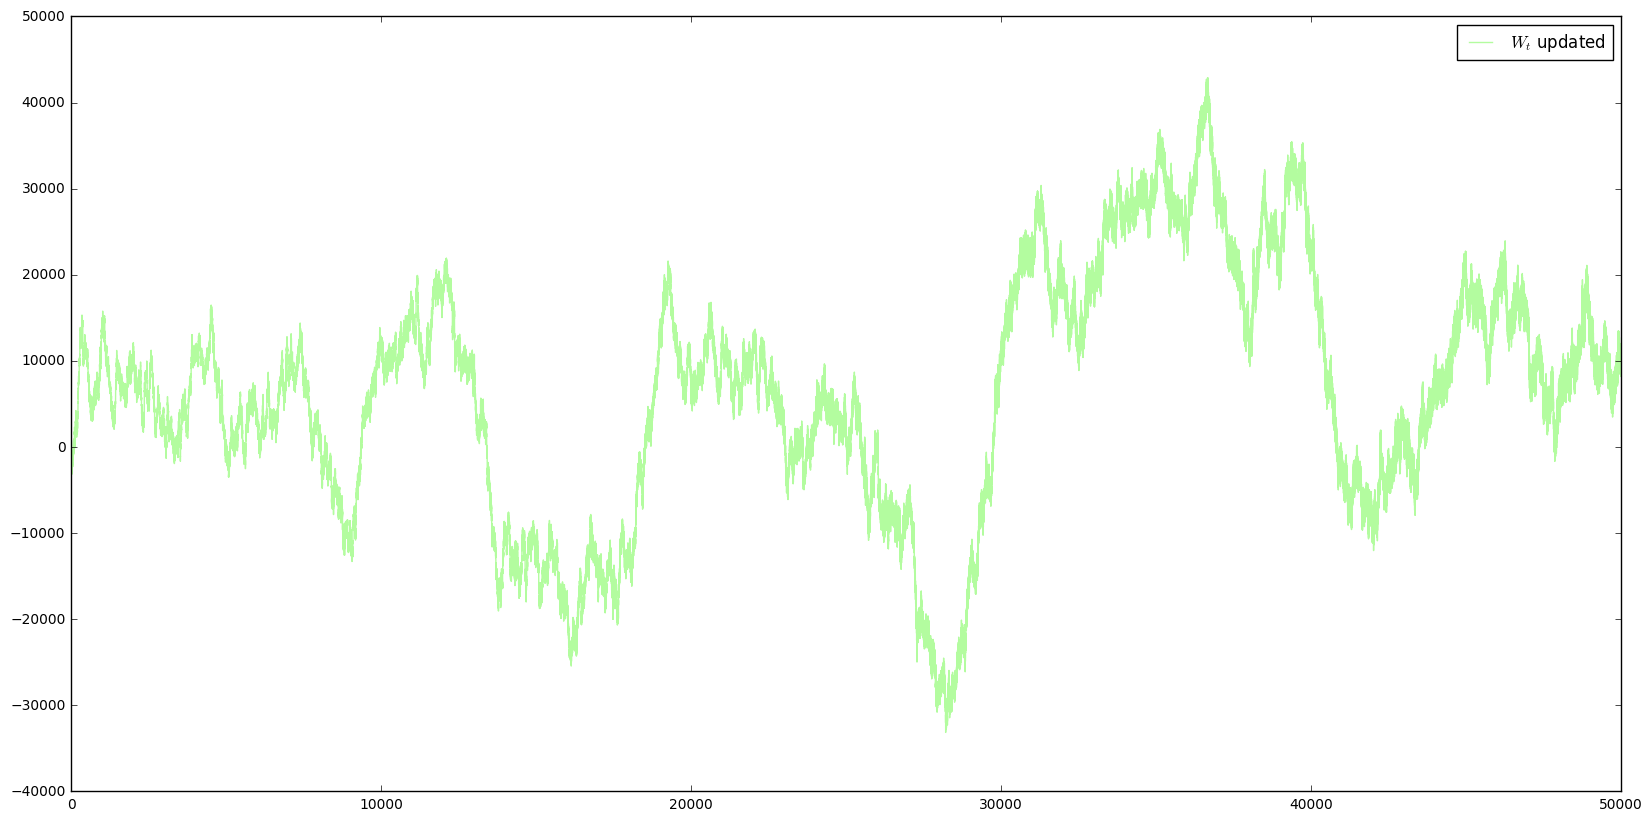

In [11]:
# Выглядит круто :)
plt.figure(figsize=(20,10))
plt.plot(times, vals, color = color_generator(), label ='$W_t$ updated')
plt.legend()
plt.show()

In [99]:
# Загрузим траектории из данных нам файлов. В каждом файле по 10 траекторий! То есть еще нужно будет каждый файл посплитить
trajs = []
for i in tqdm(range(1,11)):
    with open('/Users/semenfedotov/Downloads/winer_paths_' + str(i) + '.txt', 'r+') as f:
        trajs.append(list(map(float,f.read().split())))
        f.close()


100%|██████████| 10/10 [00:36<00:00,  3.57s/it]


In [16]:
# Разбиваем каждый файл на 10, каждая траектория длины 500000
trajectories = []
for traj in tqdm((trajs)):
    for i in range(10):
        trajectories.append(traj[i * 500000: (i + 1) * 500000])

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


100%|██████████| 25/25 [00:01<00:00, 14.46it/s]


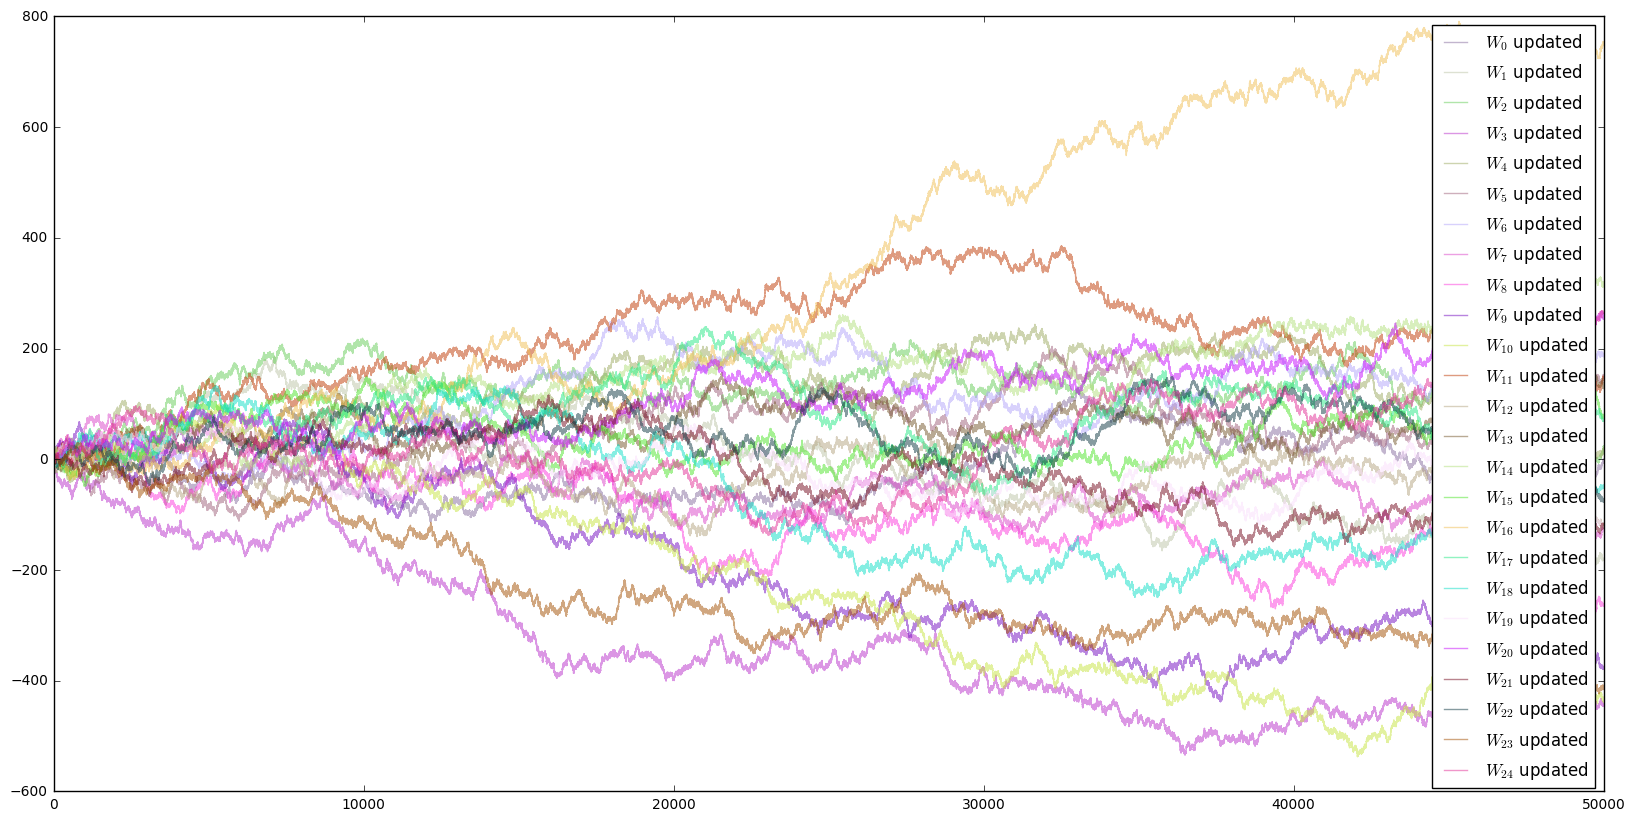

In [20]:
plt.figure(figsize=(20,10))
for i in tqdm(range(25)):
    plt.plot(times, trajectories[i], color = color_generator(), label ='$W_{' + str(i) + '}$ updated', alpha = 0.5)
plt.legend()
plt.show()


100%|██████████| 50/50 [00:10<00:00,  3.55it/s]


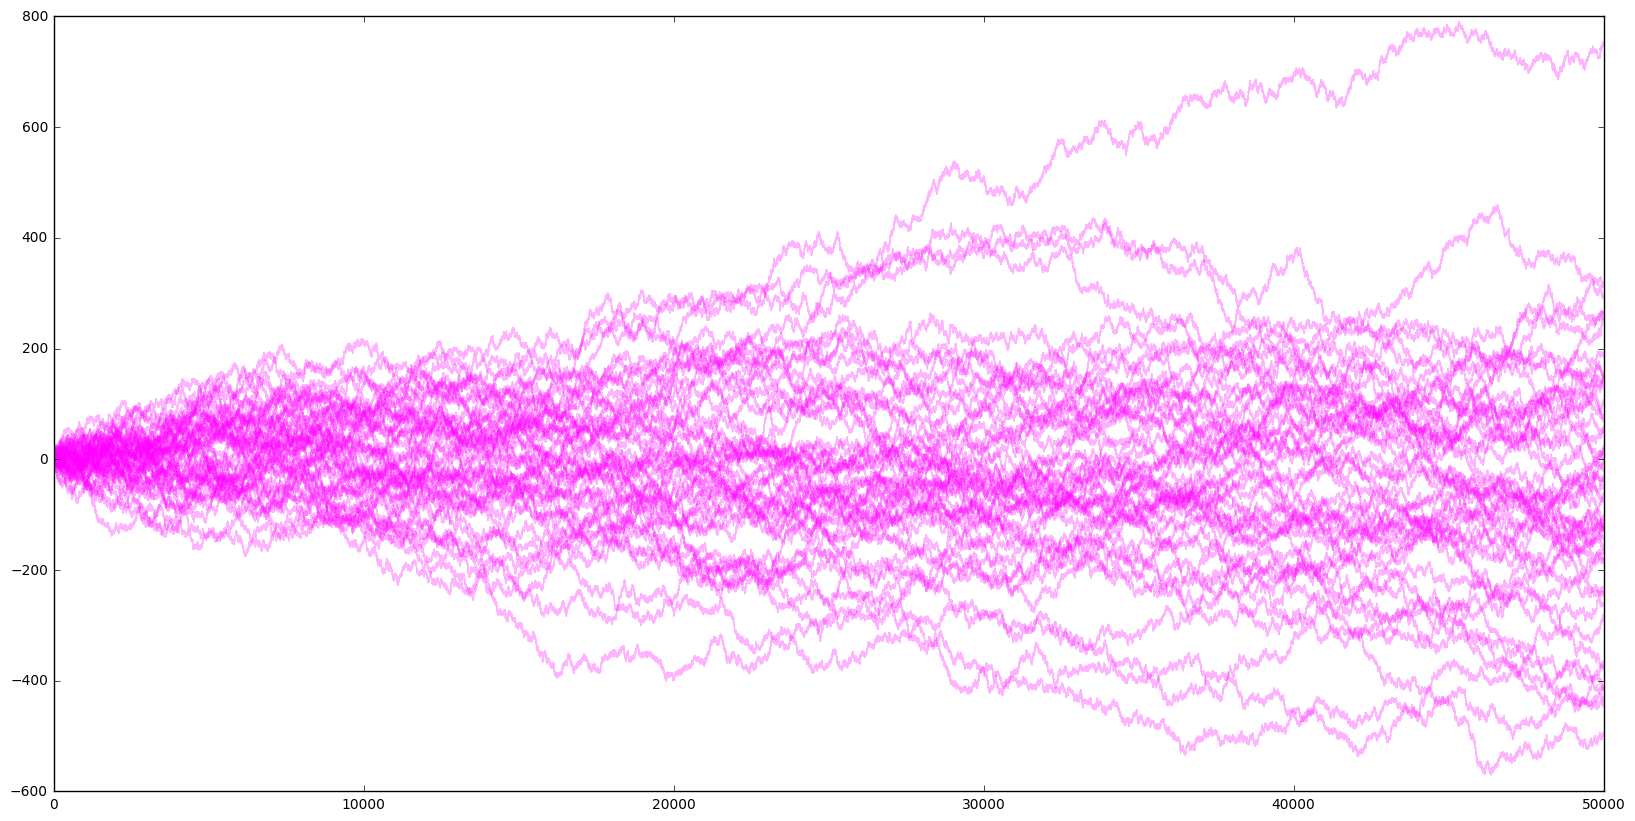

In [98]:
plt.figure(figsize=(20,10))
for i in tqdm(range(50)):
    plt.plot(times, trajectories[i], color = 'magenta', alpha = 0.3)
plt.show()

100%|██████████| 100/100 [00:07<00:00,  7.94it/s]


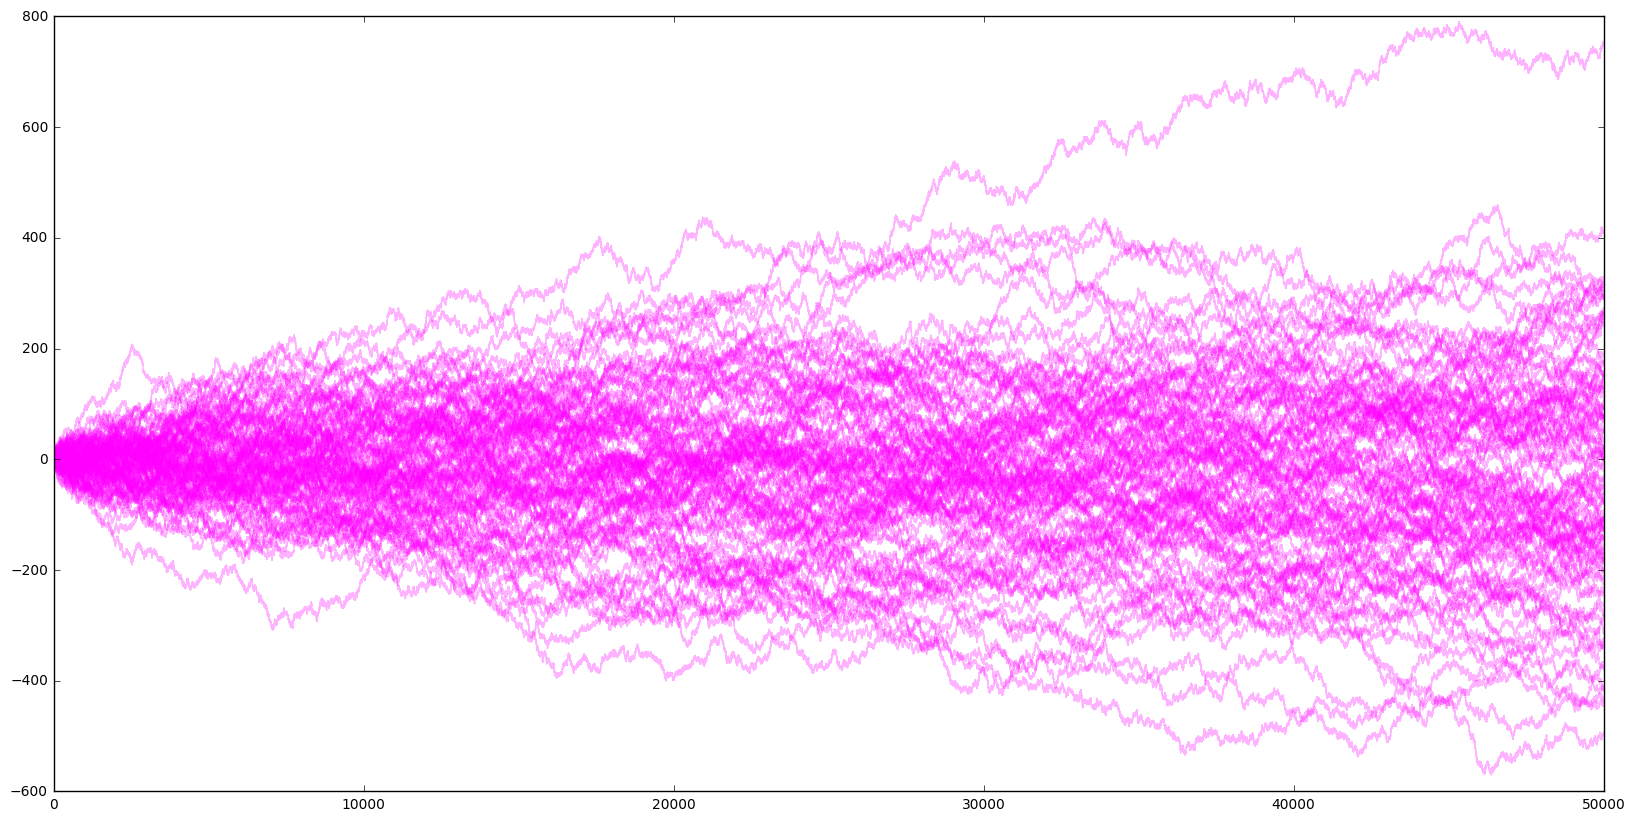

In [22]:
plt.figure(figsize=(20,10))
for i in tqdm(range(100)):
    plt.plot(times, trajectories[i], color = 'magenta', alpha = 0.3)
plt.show()

100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


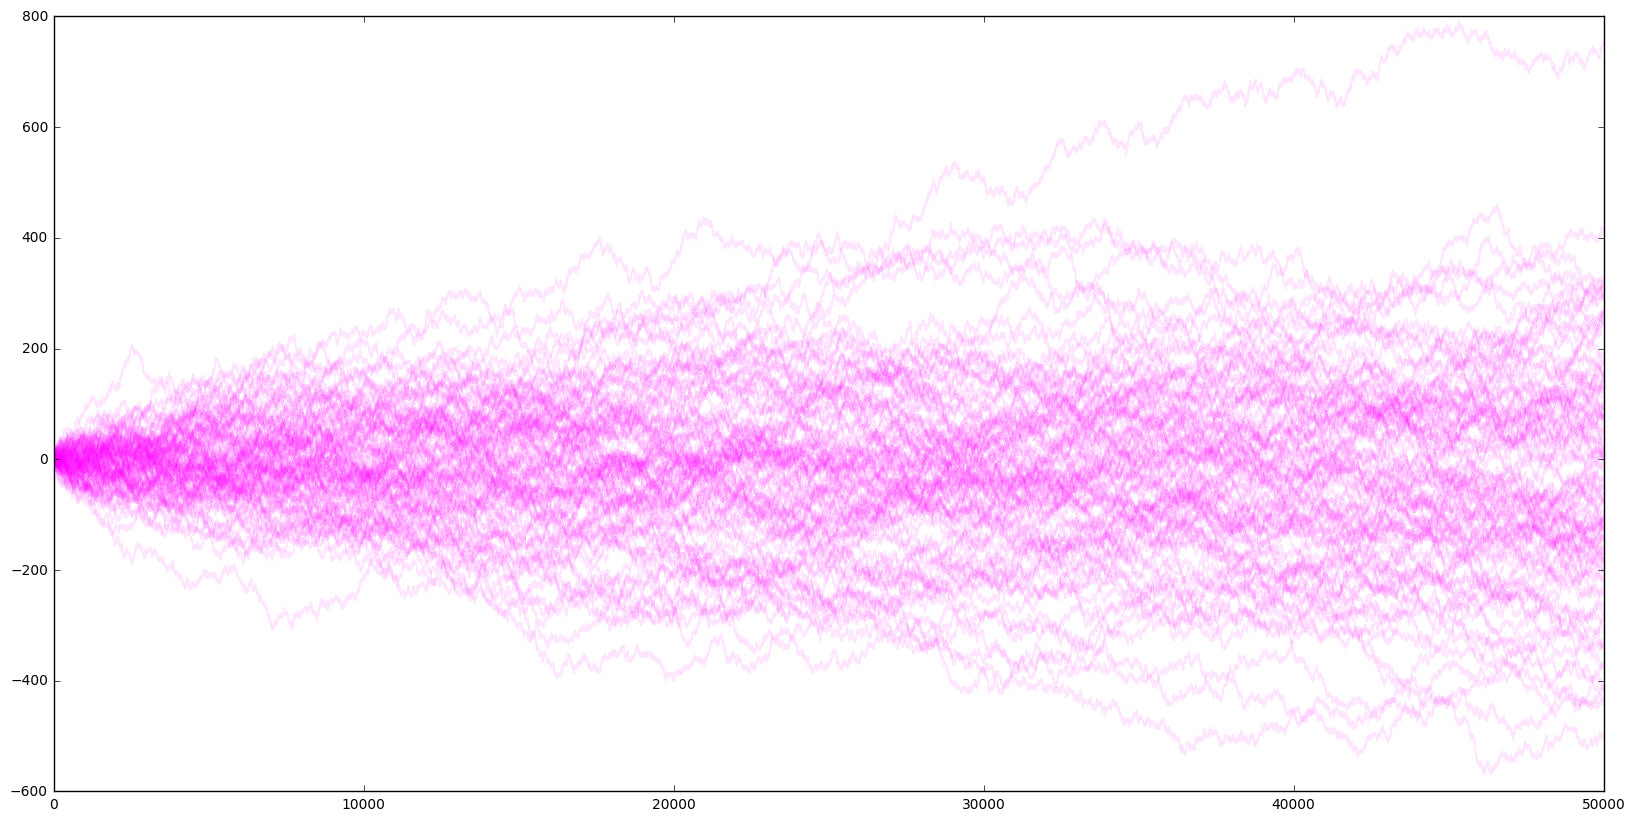

In [23]:
# Построим все траектории :)
plt.figure(figsize=(20,10))
for i in tqdm(range(100)):
    plt.plot(times, trajectories[i], color = 'magenta', alpha = 0.1)
plt.show()

In [31]:
#Посчитаем, где находятся нули траекторий, данных нам
max_null_in_traj = []
for traj in tqdm(trajectories):
    rev = list(reversed(traj))
    for ind in range(len(rev) - 2):
        if (rev[ind] >= 0 and rev[ind + 1] <= 0) or (rev[ind] <= 0 and rev[ind + 1] >= 0):
            max_null_in_traj.append(len(traj) - ind - 1)
            break

100%|██████████| 100/100 [00:11<00:00,  5.77it/s]


Можем построить доверительный интервал для среднего, для этого сделаем бутсрепную выборку и посчитаем на ней среднее. Бустреп будем делать по схеме с повторениями. Возьмем квантили и все ок

# Буду делать первый пункт, про распределения максимума нулей на отрезке для винеровского процесса.

In [52]:
# Генерация бутстрепных выборок с повторениями
bootstrap_t = []
for k in tqdm(range(10, 1000, 5)):
    to_push = []
    for i in (range(10 ** 3)):
        to_push.append(np.mean([max_null_in_traj[random.randint(0, len(max_null_in_traj) - 1)] for ind in range(k)]))
    bootstrap_t.append(to_push)

100%|██████████| 198/198 [02:54<00:00,  1.66s/it]


In [55]:
# Через квантили построим границы доверительные интервалы
bounds = []
for boot in tqdm(bootstrap_t):
    bounds.append((np.percentile(boot, 0.025), np.percentile(boot, 0.095)))


100%|██████████| 198/198 [00:00<00:00, 2285.29it/s]


In [60]:
bounds = np.array(bounds)

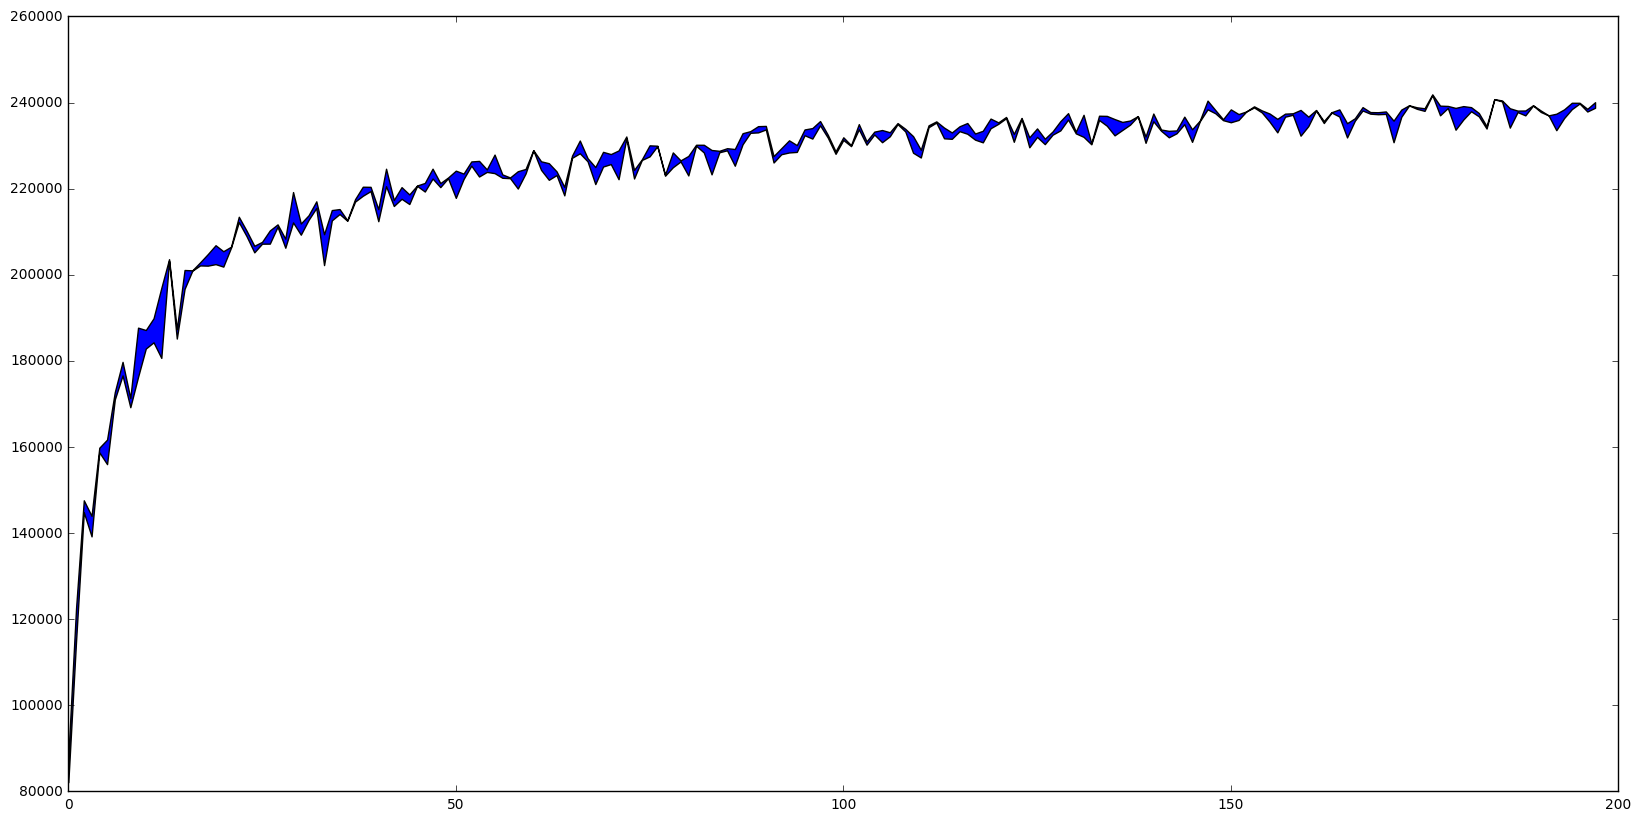

In [62]:
# Это доверительные интервалы в зависимости от размера бутстрепных выборок
plt.figure(figsize=(20, 10))
plt.fill_between(range(len(bounds)), bounds[:,0], bounds[:,1])
plt.show()

In [64]:
from statsmodels.distributions.empirical_distribution import ECDF

In [66]:
ecdf = ECDF(max_null_in_traj)


In [81]:
assumed_dist = sps.beta(0.5,0.5)

In [85]:
assumed_dist.cdf(2)
dots_beta = np.linspace(0, 1.,500000)

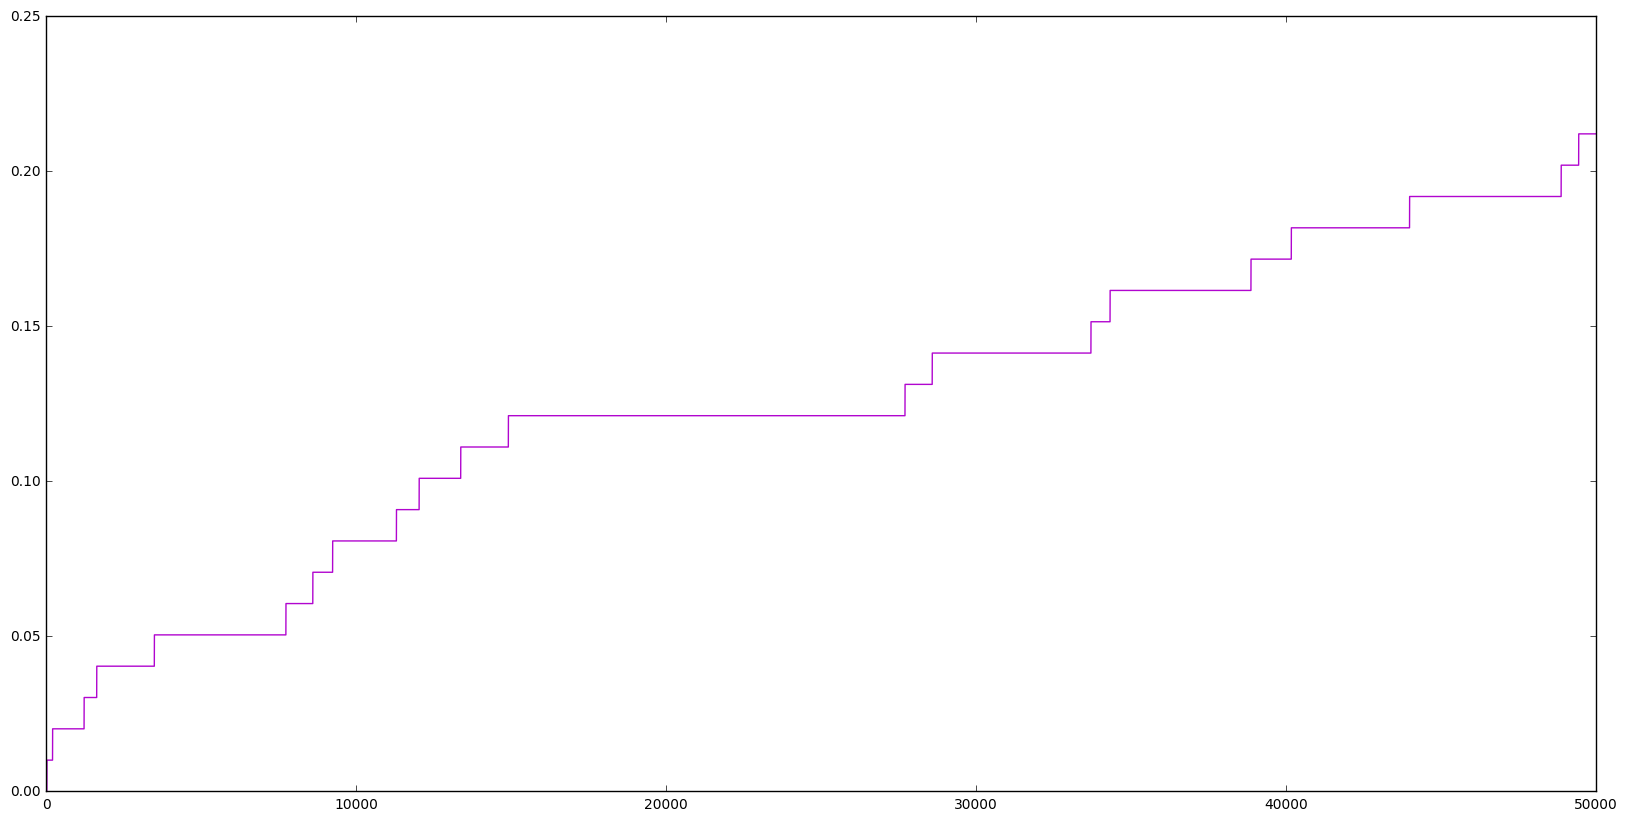

In [113]:
# Эмпирическая функция распределения
dots = np.arange(0, 50000, 0.1)
plt.figure(figsize=(20, 10))
plt.plot(dots, ecdf(dots), color= color_generator())
plt.show()

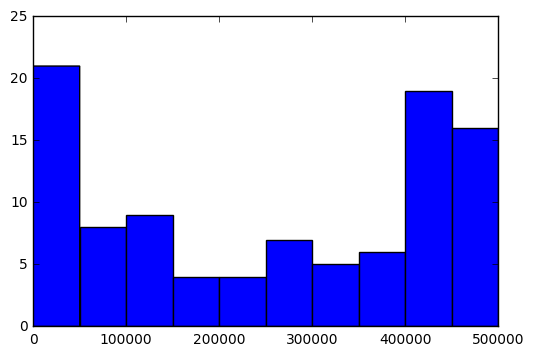

In [80]:
plt.hist(max_null_in_traj, bins=10)
plt.show()

На бета распределение очень похоже с параметрами (0.5, 0.5)

In [97]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/1200px-Beta_distribution_pdf.svg.png", width='400', height='200'>

Попробуем прийти к этому теоретически!
Найдем вероятность того, что на интервале (s, t)  есть хотя бы 1 нуль процесса $X_t$. Обозначим это событие $A_{s,t}$.
  $P(A_{s,t}) = \int\limits_{-\infty}^{\infty} P(A_{s,t} | X_s = x) f_s(x)dx = 2 \cdot \int\limits_{-\infty}^{0} P(A_{s,t} | X_s = x) f_s(x) dx$, где $f_s(x)$ - плотность $X_t$. Предыдущие равенства верны по формуле полной вероятности в интегральной форме и потому что наше распределение симметрично относительно нуля. Верно, что $P(A_{s,t} | X_s = -x) = P(\tau_x < t - s)$, где $\tau_x = min\lbrace t \geq 0: X_t = x\rbrace$. Также на семинарах было доказано, что $\tau_y$ - момент остановки(т.к. по Закону Повторного Логарифма). Почему это верно? $P(A_{s,t} | X_s = -x) = P(\tau_x < t - s)$. Потому что событие, что есть ноль на интервале от s до t, зная, что $X_s = -x$, значит то, что процесс должен подняться на х в этом интервале. а $\tau_x < t - s$ значит, что первый момент времени , когда достанем точку х наступит раньше чем длина интервала. Так же можно было сказать, что это верно по Марковскому свойству $(X_t = W_{t + a} - W_a)$ - винеровский. А в нашем случае еще верно строго Марковское св-во: вместо a можно взять  момент остановки. Ну тогда $P(A_{s,t}) = \int\limits_{0}^{+\infty}\int\limits_{0}^{t - s} g_x(u) \cdot f_s(-x)dudx$, где $g_x(y)$ - плотность $tau_x$, которая была посчитана нами на семинарах и равна: $g_y(t) = \frac{y}{\sqrt{2\pi t^3}} \cdot \exp(-\frac{y^2}{-2t}), t \in (0, +\infty)$.
 $f_s(x)$ - плотность случайной величины  $\xi \sim \mathcal{N}(0, s)$ 
  
  
  $P(A_{s,t}) = \frac{1}{\pi \sqrt{s}} \int\limits_{0}^{t - s} u^{-\frac{3}{2}}\int\limits_{0}^{+\infty} x \cdot \exp{( -\frac{1}{2}x^2(\frac{u + s}{u \cdot s}) )} dxdu = \frac{\sqrt{s}}{\pi}\int\limits_{0}^{t - s} \frac{1}{(u + s)\sqrt{u}}du$. Теперь произведем замену $v = \sqrt{\frac{u}{s}}$, тогда получим: $P(A_{s,t}) = \frac{2}{\pi} \int\limits_{0}^{\sqrt{\frac{t}{s - 1}}} \frac{1}{v^2 + 1} dv = \frac{2}{\pi} \arctan(\sqrt{\frac{t}{s} - 1}) = 1 - \frac{2}{\pi} \arcsin(\sqrt{\frac{s}{t}})$.
  Если посчитать вероятность $P(A_{0, t}) = 1$, т.к. arcsin(0) = 0. Теперь введем случайную величину $Y_t = \max\lbrace s \in [0, t] : X_s = 0 \rbrace$  (Максимальный ноль на отрезке от 0 до t). Найдем ее распределение:  для $s \in (0, t) $ событие $\lbrace Y_t <= s\rbrace$ эквивалентно тому, что на интервале (s, t) нет нулей! А это мы считали выше: $P(Y_t <= s) = P(\overline{A_{s,t}}) = 1 - P(A_{s,t}) = \frac{2}{\pi} \arcsin(\sqrt{\frac{s}{t}})$. Получаем, что у максимального нуля Винеровского процесса распределение арксинусное. А арксинусное распределение - частный случай Бета распределения с параметрами $\alpha = \beta = \frac{1}{2}$. Но у стандартного арксинусного распределения $U, P(U <= s) = \frac{2}{\pi} \arcsin(\sqrt{s})$,а у гас $P(Z_t <= s) = \frac{2}{\pi} \arcsin(\sqrt{\frac{s}{t}}) = P(U <= \frac{s}{t})$. Т.е. это просто функция распределения для U в точке $\frac{s}{t}$. Ну а плотность измениться так: $p_{Z_t}(s) = p_U(\frac{s}{t}) \cdot \frac{1}{\sqrt{t}}$. Т.е наша $Z_t = U * t$, т.к. $P(U * t \leq s) = P(U \leq \frac{s}{t}) = \frac{2}{\pi} \arcsin(\sqrt{\frac{s}{t}})$. А стандартное арксинусное $\xi \sim Beta(\frac{1}{2}, \frac{1}{2})$. Осталось узнать, что будет, если домножить сл. величину, распределенную, как Бета , домножить на константу. получим, что $p_{t * \xi}(x) = p_\xi(\frac{x}{t}) * \frac{1}{t}$. Вот, именно такое распределение и будет иметь максимум нуля на отрезке [0, t].

# ВЫВОД:
Мы получили, что максимум нулей на отрезке [0, t] распределен как $\sim t * Beta(\frac{1}{2}, \frac{1}{2})$. Супер!!!
Матожидание его равно: $t * \frac{\alpha}{\alpha + \beta} = \frac{t* \frac{1}{2}}{1} = \frac{t}{2}$. А дисперсия станет $D[X] = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)} * t^2 = \frac{\frac{1}{4}}{2} * t^2 = \frac{1}{8} * t^2$. Оно совпадает с Arcsine – bounded support распределением с параметрами a = 0, b = t